In [ ]:
# ПОПРОБОВАТЬ, свежее
# https://www.kaggle.com/cttsai/smote-on-lgbm-w-ideas-from-kernels-and-discussion

In [20]:
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
# https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail

**Важно.**

Если мы делаем семплинг для балансирования классов, то валидационная выборка должна быть неизменна! 
То есть для валидации мы берем из исходной (неизменной) обучающей выборки!


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('scripts')
from common import *
from global_common import *
from models import *
from load_and_proccess_data import *

In [3]:
train_df, test_df, columns_type_dict = load_data()

Целочисленных переменных  : 236
Переменных с плавающей точкой : 225
Из целочисленныъ - 4 бинарных.
Переменным присвоен соответствующий тип.


In [4]:
# Для валидации нам нужна отложенная выборка.
train_idxs, holdout_idxs, _, _ = train_test_split(train.index.values, 
                                                train.target.values, 
                                                stratify=train.target.values,
                                                test_size=0.2, 
                                            
                                                random_state=SEED)
holdout = train.iloc[holdout_idxs, :].copy()
holdout.reset_index(inplace=True, drop=True)
train = train.iloc[train_idxs, :].copy()
train.reset_index(inplace=True, drop=True)

print(f'Обучающая выборка : {train.shape}')
print(f'Отложенная выборка : {holdout.shape}')

Обучающая выборка : (56107, 461)
Отложенная выборка : (14027, 461)


Пробуем без ресемплинга. Обучающую выборку делим на 5 фолдов и валидируем каждый фолд по отложенной выборке.

In [5]:
# TODO: Убрать дерево в скпирт, спецаильно для валидации семплинга

def run_lightgmb(lgb_params, cat_names, train, test, holdout):
    # Prepare dataset for training
    cols_to_drop = [
        'id',
        'target',
    ]

    categorical = cat_names

    X = train.drop(cols_to_drop, axis=1, errors='ignore')
    y = train.target.values
    
    X_holdout = holdout.drop(cols_to_drop, axis=1, errors='ignore')
    y_holdout = holdout.target.values

    id_test = test.id.values
    X_test = test.drop(cols_to_drop[0], axis=1, errors='ignore')


    print('train.shape = {}, test.shape = {}'.format(train.shape, test.shape))

    # Build the model
    cnt = 0
    p_buf = []
    n_splits = 5
    n_repeats = 1
    kf = StratifiedKFold(
        n_splits=n_splits, 
#         random_state=0)
    )
    err_buf = []   

    n_features = X.shape[1]

    for train_index, valid_index in kf.split(X, y):
        print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
        params = lgb_params.copy() 

        lgb_train = lgb.Dataset(
            X.iloc[train_index], 
            y[train_index], 
            categorical_feature=categorical,

            )
        lgb_train.raw_data = None

        lgb_valid = lgb.Dataset(
            X_holdout, 
            y_holdout,
            categorical_feature=categorical,
            )
        lgb_valid.raw_data = None

 

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=100000,
            valid_sets=[lgb_train, lgb_valid],
            early_stopping_rounds=150, 
            verbose_eval=100,
        )

        if cnt == 0:
            importance = model.feature_importance()
            model_fnames = model.feature_name()
            tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
            tuples = [x for x in tuples if x[1] > 0]
            print('Important features:')
            for i in range(60):
                if i < len(tuples):
                    print(tuples[i])
                else:
                    break

            del importance, model_fnames, tuples
        

        p = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
        err = roc_auc_score(y[valid_index], p)

        print('{} holdout auc: {}'.format(cnt + 1, err))
        
        p = model.predict(X_holdout, num_iteration=model.best_iteration)
        holdout_err = roc_auc_score(y_holdout, p)

        p = model.predict(X_test, num_iteration=model.best_iteration)
        if len(p_buf) == 0:
            p_buf = np.array(p, dtype=np.float16)
        else:
            p_buf += np.array(p, dtype=np.float16)
        err_buf.append(err)


        cnt += 1
    
        del model, lgb_train, lgb_valid, p
        gc.collect

    err_mean = np.mean(err_buf)
    err_std = np.std(err_buf)
    print('auc = {:.6f} +/- {:.6f}'.format(err_mean, err_std))

    preds = p_buf/cnt
    return preds

In [6]:
lgb_params = {
        'num_leaves' : 16,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 5,
        'learning_rate': 0.01, 
        'verbose': -1,
        'num_threads': 8,
        'is_unbalanced' : 'true',
    }

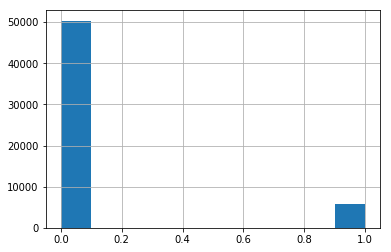

In [7]:
train.target.hist();

In [9]:
predictions_default = run_lightgmb(lgb_params, cat_names, train, test, holdout)

train.shape = (56107, 461), test.shape = (30058, 460)
Fold 1/5*1
Training until validation scores don't improve for 150 rounds.
[100]	training's auc: 0.802515	valid_1's auc: 0.772811
[200]	training's auc: 0.830541	valid_1's auc: 0.798758
[300]	training's auc: 0.848241	valid_1's auc: 0.810589
[400]	training's auc: 0.860559	valid_1's auc: 0.816417
[500]	training's auc: 0.869837	valid_1's auc: 0.819378
[600]	training's auc: 0.878548	valid_1's auc: 0.82109
[700]	training's auc: 0.886368	valid_1's auc: 0.822472
[800]	training's auc: 0.893539	valid_1's auc: 0.823262
[900]	training's auc: 0.899748	valid_1's auc: 0.823713
[1000]	training's auc: 0.90537	valid_1's auc: 0.824232
[1100]	training's auc: 0.910202	valid_1's auc: 0.824428
[1200]	training's auc: 0.914365	valid_1's auc: 0.824539
[1300]	training's auc: 0.918591	valid_1's auc: 0.824703
[1400]	training's auc: 0.922147	valid_1's auc: 0.824636
Early stopping, best iteration is:
[1299]	training's auc: 0.918543	valid_1's auc: 0.824717
Importan

In [100]:
# 5 holdout auc: 0.8353810961311395
# auc = 0.835980 +/- 0.004638

Теперь для того, чтобы сбалансировать классы в обучающей выборке продублируем случайнные семплы из класса в маленьким кол-во семплов.

In [17]:
# Class count
count_class_0, count_class_1 = train.target.value_counts()

# Divide by class
df_class_0 = train[train['target'] == 0]
df_class_1 = train[train['target'] == 1]

In [18]:
# # Undersampling
# df_class_0_under = df_class_0.sample(count_class_1)
# df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

# print('Random under-sampling:')
# print(df_test_under.target.value_counts())

# df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

Random over-sampling:
0    53493
1    48143
Name: target, dtype: int64


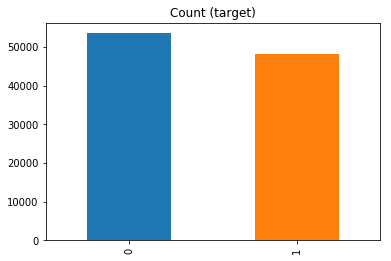

In [38]:
df_class_1_over = df_class_1.sample(int(count_class_0 * 0.9), replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [36]:
train = df_test_over.copy()

In [57]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority', n_jobs=8, random_state=17)

In [58]:
train_sm, y_sm = smote.fit_sample(train.iloc[:, 1:], train['target'].values)
columns = train.columns[1:]
x = pd.DataFrame(train_sm, columns=columns)
x.target.hist();

In [67]:
lgb_params = {
        'num_leaves' : 16,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': 5,
        'learning_rate': 0.01, 
        'verbose': -1,
        'num_threads': 8,
#         'scale_pos_weight' : 5,
    }

p = run_lightgmb(lgb_params, cat_names, x, test, holdout)

train.shape = (106986, 460), test.shape = (30058, 460)
Fold 1/5*1
Training until validation scores don't improve for 250 rounds.
[100]	training's auc: 0.821807	valid_1's auc: 0.753106
[200]	training's auc: 0.847521	valid_1's auc: 0.77697
[300]	training's auc: 0.863502	valid_1's auc: 0.788827
[400]	training's auc: 0.875963	valid_1's auc: 0.79794
[500]	training's auc: 0.884922	valid_1's auc: 0.802841
[600]	training's auc: 0.892401	valid_1's auc: 0.806238
[700]	training's auc: 0.899086	valid_1's auc: 0.808065
[800]	training's auc: 0.904691	valid_1's auc: 0.809329
[900]	training's auc: 0.909799	valid_1's auc: 0.810274
[1000]	training's auc: 0.914146	valid_1's auc: 0.811011
[1100]	training's auc: 0.918069	valid_1's auc: 0.811103
[1200]	training's auc: 0.921707	valid_1's auc: 0.81109
[1300]	training's auc: 0.925138	valid_1's auc: 0.811055
[1400]	training's auc: 0.928458	valid_1's auc: 0.811127
[1500]	training's auc: 0.931565	valid_1's auc: 0.810952
[1600]	training's auc: 0.934446	valid_1's a

In [6]:
# Проверим на отложенной выборке. Внимательно, модель из последнего фолда.
# Потому что мы не сохраняем модели из каждого фолда.
cols_to_drop = [
        'id',
        'target',
    ]

X = train.drop(cols_to_drop, axis=1, errors='ignore')
y = train.target.values

In [7]:
import imblearn

In [8]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

Removed indexes: [ 5066 29060  4372 19133 ... 70119 70128 70129 70132]


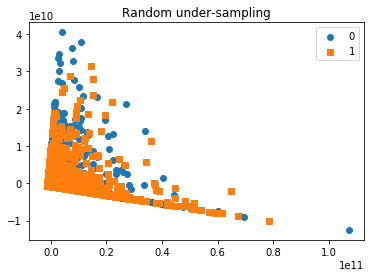

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

55734 new random picked points


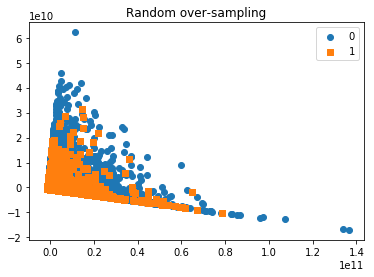

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

Removed indexes: [    0     1     2     3 ... 70130 70131 70132 70133]


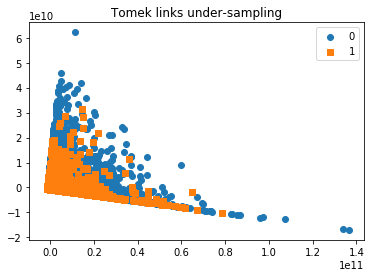

In [13]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

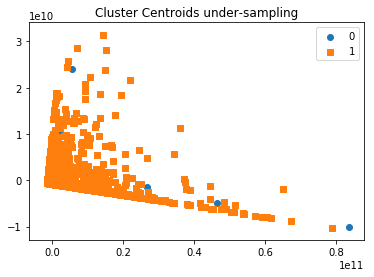

In [14]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 10})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

In [ ]:
# Prepare submission
subm = pd.DataFrame()
subm['id'] = test_df.id.values
subm['prediction'] = mergid_preds
subm.to_csv('submissions/hope.csv', index=False)